In [2]:
! pip install tqdm

In [3]:
import numpy as np
from autogluon.tabular import TabularPredictor
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

In [5]:
# Smote미적용
from sklearn.tree import DecisionTreeClassifier
num_features = [
    "Contract_period",
    "Age",
    "Avg_additional_charges_total",
    "Month_to_end_contract",
    "Lifetime",
    "Avg_class_frequency_total",
    "Avg_class_frequency_current_month",
    "social_connected",
    "avg_monthly_add_charge",
    "class_freq_ratio"]

df = pd.read_csv("gym_churn_us.csv")
df = df.rename(columns={"Churn": "target"})
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
X['social_connected'] = X['Partner'] + X['Promo_friends'] + X['Group_visits']   # 고객의 사회적 연결이 얼마나 되어있는지 나타내는 피쳐
X['avg_monthly_add_charge'] = X['Avg_additional_charges_total'] / (X['Lifetime'] + 1)   # 평균 추가 요금의 시간 기준 비율
X['class_freq_ratio'] = X['Avg_class_frequency_current_month'] / (X['Avg_class_frequency_total'] + 1e-5)    # 클래스 이용 변화율 (최근 대비 전체)
X['class_freq_change'] = X['Avg_class_frequency_current_month'] - X['Avg_class_frequency_total']    # 이용 행동 변화량
X['contract_ending_soon'] = (X['Month_to_end_contract'] <= 1).astype(int)      # 계약 만료 임박 여부 (1개월 이내)
X['social_connected_ratio'] = (X['Partner'] + X['Promo_friends'] + X['Group_visits']) / 3     # 사회적 연결의 강도 비율

ss = StandardScaler()
X[num_features] = ss.fit_transform(X[num_features])
dtc = DecisionTreeClassifier()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred = cross_val_predict(dtc, X, y, cv=cv)
print(classification_report(y,y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9528    0.9486    0.9507      2939
           1     0.8594    0.8699    0.8646      1061

    accuracy                         0.9277      4000
   macro avg     0.9061    0.9093    0.9077      4000
weighted avg     0.9281    0.9277    0.9279      4000



In [6]:
# SMOTE 적용
from imblearn.pipeline import Pipeline as ImbPipeline

pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', DecisionTreeClassifier())
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


y_pred = cross_val_predict(pipeline, X[num_features], y, cv=cv)

print(classification_report(y, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9524    0.9394    0.9459      2939
           1     0.8383    0.8699    0.8538      1061

    accuracy                         0.9210      4000
   macro avg     0.8954    0.9047    0.8999      4000
weighted avg     0.9221    0.9210    0.9215      4000



In [7]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score
from imblearn.pipeline import Pipeline as ImbPipeline

# 이진 분류 모델들
models = {
    'Logistic Regression' : LogisticRegression(random_state=42),
    'Ridge Classifier' : RidgeClassifier(random_state=42),
    'Random Forest' : RandomForestClassifier(random_state=42),
    'XGBoost' : XGBClassifier(random_state=42),
    'LightGBM' : LGBMClassifier(random_state=42),
    'CatBoostClassifier' : CatBoostClassifier(logging_level='Silent',random_state=42)
}

# 교차검증 설정
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 결과 저장
results = {}

for name, model in models.items():
    print(f"\n Model: {name}")
    
    # 파이프라인 구성
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])
    
    # 교차검증 예측
    y_pred = cross_val_predict(pipeline, X[num_features], y, cv=cv)
    
    # 분류 리포트 출력 및 저장
    print("F1 Score:", f1_score(y, y_pred, average='weighted'))
    report = classification_report(y, y_pred, digits=4, output_dict=False)
    print(report)


 Model: Logistic Regression
F1 Score: 0.9195178255372946
              precision    recall  f1-score   support

           0     0.9661    0.9207    0.9429      2939
           1     0.8057    0.9105    0.8549      1061

    accuracy                         0.9180      4000
   macro avg     0.8859    0.9156    0.8989      4000
weighted avg     0.9235    0.9180    0.9195      4000


 Model: Ridge Classifier
F1 Score: 0.9149767452076085
              precision    recall  f1-score   support

           0     0.9609    0.9197    0.9398      2939
           1     0.8012    0.8963    0.8461      1061

    accuracy                         0.9135      4000
   macro avg     0.8810    0.9080    0.8930      4000
weighted avg     0.9185    0.9135    0.9150      4000


 Model: Random Forest
F1 Score: 0.9453073678018209
              precision    recall  f1-score   support

           0     0.9638    0.9616    0.9627      2939
           1     0.8942    0.9001    0.8971      1061

    accuracy     

### catboost grid search

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report
from catboost import CatBoostClassifier

# 표준화
ss = StandardScaler()
X[num_features] = ss.fit_transform(X[num_features])

# Stratified K-Fold 정의
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# CatBoostClassifier와 하이퍼파라미터 그리드
param_grid = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [100, 300, 500],
    'l2_leaf_reg': [1, 3, 5, 7],
    'border_count': [32, 64, 128],
    'bagging_temperature': [0, 0.5, 1.0],
    'random_strength': [1, 5, 10]
}

model = CatBoostClassifier(verbose=0, random_state=42)

# GridSearchCV 객체 생성
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1',
    cv=cv,
    n_jobs=-1
)

# 학습
grid_search.fit(X, y)

# 결과 출력
print("Best Params:", grid_search.best_params_)
print("Best F1 Score (CV):", grid_search.best_score_)

KeyboardInterrupt: 

# automl

In [102]:
# 각 모델 1번씩 피트
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import pandas as pd
from autogluon.tabular import TabularPredictor
from sklearn.metrics import classification_report

# 데이터 로딩 및 피처 엔지니어링
df = pd.read_csv("C:/Users/Playdata/Desktop/project2/gym_churn_us.csv")
df = df.rename(columns={"Churn": "target"})
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# 추가 피처 생성
X['social_connected'] = X['Partner'] + X['Promo_friends'] + X['Group_visits']
X['avg_monthly_add_charge'] = X['Avg_additional_charges_total'] / (X['Lifetime'] + 1)
X['class_freq_ratio'] = X['Avg_class_frequency_current_month'] / (X['Avg_class_frequency_total'] + 1e-5)
X['class_freq_change'] = X['Avg_class_frequency_current_month'] - X['Avg_class_frequency_total']
X['contract_ending_soon'] = (X['Month_to_end_contract'] <= 1).astype(int)
X['social_connected_ratio'] = (X['Partner'] + X['Promo_friends'] + X['Group_visits']) / 3

# 최종 데이터 통합
data = X.copy()
data['target'] = y

# 훈련/검증 데이터 분리
train_data, val_data = train_test_split(data, test_size=0.2, stratify=data['target'], random_state=42)

# SMOTE 적용
X_train = train_data.drop('target', axis=1)
y_train = train_data['target']
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 재조합
train_resampled = X_resampled.copy()
train_resampled['target'] = y_resampled

# AutoGluon 학습
time_limit = 60 * 10  # 10분
eval_metric = 'f1_weighted'

predictor = TabularPredictor(label='target', path='AutogluonModels/', eval_metric=eval_metric)
predictor.fit(train_resampled, time_limit=time_limit)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
Memory Avail:       20.14 GB / 31.64 GB (63.6%)
Disk Space Avail:   390.59 GB / 475.90 GB (82.1%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions and benchmarks.
	presets='high'         : Strong accuracy with fast inference speed.
	presets='good'         : Good accu

In [ ]:
leaderboard = predictor.leaderboard(silent=True)
leaderboard

In [104]:
# 검증 데이터에서 feature만 따로 분리
X_val = val_data.drop(columns=['target'])
y_val = val_data['target']

# 예측
y_pred = predictor.predict(X_val)

# 결과 확인 (예: 정확도, F1 점수 등)
from sklearn.metrics import f1_score, classification_report

print("F1 Score:", f1_score(y_val, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_val, y_pred, digits=4))

F1 Score: 0.9573696529459241

Classification Report:
               precision    recall  f1-score   support

           0     0.9679    0.9745    0.9712       588
           1     0.9279    0.9104    0.9190       212

    accuracy                         0.9575       800
   macro avg     0.9479    0.9424    0.9451       800
weighted avg     0.9573    0.9575    0.9574       800



In [ ]:
# 같은 모델 5번씩
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import pandas as pd
from autogluon.tabular import TabularPredictor
from sklearn.metrics import classification_report

# 데이터 로딩 및 피처 엔지니어링
df = pd.read_csv("gym_churn_us.csv")
df = df.rename(columns={"Churn": "target"})
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# 추가 피처 생성
X['social_connected'] = X['Partner'] + X['Promo_friends'] + X['Group_visits']  # 고객의 사회적 연결이 얼마나 되어있는지 나타내는 피쳐
X['avg_monthly_add_charge'] = X['Avg_additional_charges_total'] / (X['Lifetime'] + 1) # 평균 추가 요금의 시간 기준 비율
X['class_freq_ratio'] = X['Avg_class_frequency_current_month'] / (X['Avg_class_frequency_total'] + 1e-5) # 클래스 이용 변화율 (최근 대비 전체)
X['class_freq_change'] = X['Avg_class_frequency_current_month'] - X['Avg_class_frequency_total'] # 이용 행동 변화량
X['contract_ending_soon'] = (X['Month_to_end_contract'] <= 1).astype(int) # 계약 만료 임박 여부 (1개월 이내)
X['social_connected_ratio'] = (X['Partner'] + X['Promo_friends'] + X['Group_visits']) / 3 # 사회적 연결의 강도 비율

# 최종 데이터 통합
data = X.copy()
data['target'] = y

# 훈련/검증 데이터 분리
train_data, val_data = train_test_split(data, test_size=0.2, stratify=data['target'], random_state=42)

# AutoGluon 학습
time_limit = 60 * 10  # 10분
eval_metric = 'f1_weighted'

predictor = TabularPredictor(label='target', path='AutogluonModels/', eval_metric=eval_metric)
predictor.fit(train_data, time_limit=time_limit,  num_bag_folds=5, num_bag_sets=1)

In [3]:
leaderboard = predictor.leaderboard(silent=True)
leaderboard

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.962589,f1_weighted,2.435507,128.256017,0.010545,2.476614,2,True,14
1,NeuralNetTorch_BAG_L1,0.957403,f1_weighted,0.247918,59.144547,0.247918,59.144547,1,True,12
2,LightGBMXT_BAG_L1,0.956736,f1_weighted,0.065634,14.110264,0.065634,14.110264,1,True,3
3,CatBoost_BAG_L1,0.956607,f1_weighted,0.036101,13.166572,0.036101,13.166572,1,True,7
4,NeuralNetFastAI_BAG_L1,0.956266,f1_weighted,0.274278,31.520204,0.274278,31.520204,1,True,10
5,XGBoost_BAG_L1,0.955780,f1_weighted,0.064086,8.463043,0.064086,8.463043,1,True,11
6,LightGBM_BAG_L1,0.954916,f1_weighted,0.044663,13.989451,0.044663,13.989451,1,True,4
7,LightGBMLarge_BAG_L1,0.953101,f1_weighted,0.073472,27.243172,0.073472,27.243172,1,True,13
8,RandomForestGini_BAG_L1,0.951338,f1_weighted,0.568464,2.632151,0.568464,2.632151,1,True,5
9,RandomForestEntr_BAG_L1,0.951276,f1_weighted,0.589511,2.537373,0.589511,2.537373,1,True,6


In [4]:
# 검증 데이터에서 feature만 따로 분리
X_val = val_data.drop(columns=['target'])
y_val = val_data['target']

# 예측
y_pred = predictor.predict(X_val)

# 결과 확인 (예: 정확도, F1 점수 등)
from sklearn.metrics import f1_score, classification_report

print("F1 Score:", f1_score(y_val, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_val, y_pred, digits=4))

C:\Users\Playdata\miniconda3\envs\env1\Lib\site-packages\fastai\learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")
C:\Users\Playdata\miniconda3\envs\env1\Lib\site-packages\fastai\learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code w

F1 Score: 0.9634945859386916

Classification Report:
               precision    recall  f1-score   support

           0     0.9682    0.9830    0.9755       588
           1     0.9507    0.9104    0.9301       212

    accuracy                         0.9637       800
   macro avg     0.9595    0.9467    0.9528       800
weighted avg     0.9636    0.9637    0.9635       800



### top3 voting

In [107]:
leaderboard = predictor.leaderboard(val_data, silent=True)
top3_models = leaderboard['model'].head(3).tolist()
print("Top 3 models:", top3_models)

# 각 모델로 예측 수행
preds = []
for model in top3_models:
    pred = predictor.predict(X_val, model=model)
    preds.append(pred)

import numpy as np
from scipy.stats import mode

# Stack predictions: (n_models, n_samples)
pred_array = np.vstack([p.values for p in preds])
# 하드보팅: 각 열에 대해 다수결 투표
voted_preds, _ = mode(pred_array, axis=0, keepdims=False)

from sklearn.metrics import classification_report, f1_score

print("F1 Score (Hard Voting):", f1_score(y_val, voted_preds, average='weighted'))
print("\nClassification Report:\n", classification_report(y_val, voted_preds, digits=4))

C:\Users\Playdata\miniconda3\envs\env1\Lib\site-packages\fastai\learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


Top 3 models: ['NeuralNetTorch', 'CatBoost', 'LightGBMXT']
F1 Score (Hard Voting): 0.9585911983493622

Classification Report:
               precision    recall  f1-score   support

           0     0.9680    0.9762    0.9721       588
           1     0.9324    0.9104    0.9212       212

    accuracy                         0.9587       800
   macro avg     0.9502    0.9433    0.9466       800
weighted avg     0.9585    0.9587    0.9586       800



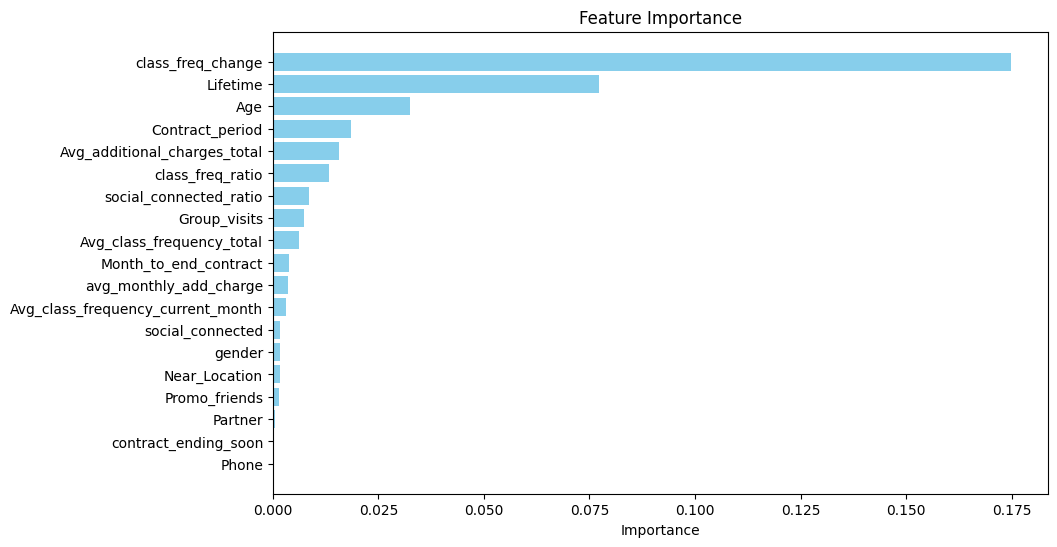

In [108]:
# feature_importance의 중요도 컬럼과 피쳐 이름을 합치기
importance_df = feature_importance[['importance']].copy()

# feature_importance에 포함된 피쳐 이름 확인
important_features = importance_df.index  # index는 피쳐 이름을 나타냄

# train_data의 피쳐 이름이 feature_importance와 맞는지 확인
train_features = train_data.columns

# 일치하는 피쳐 이름만 사용
matching_features = [feature for feature in train_features if feature in important_features]

# 중요도를 내림차순으로 정렬
importance_df = importance_df.loc[matching_features]
importance_df = importance_df.sort_values(by='importance', ascending=True)

# 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_df.index, importance_df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

### 전체데이터

In [5]:
result_df = data.copy()
preds = predictor.predict(data)
result_df['predict'] = preds
preds_proba = predictor.predict_proba(data)
result_df['predict_proba'] = preds_proba.iloc[:,1]

labels = []
for proba in result_df['predict_proba']:
  if proba >= 0.9:
    labels += [2]
  elif 0.5 <= proba <0.9:
    labels += [1]
  else:
    labels += [0]

result_df['predict_proba'] = labels

C:\Users\Playdata\miniconda3\envs\env1\Lib\site-packages\fastai\learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")
C:\Users\Playdata\miniconda3\envs\env1\Lib\site-packages\fastai\learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code w

<Axes: >

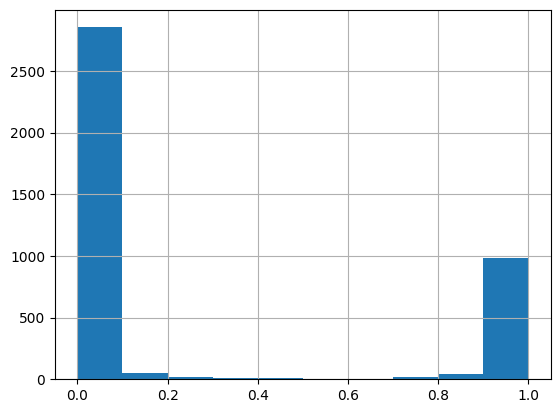

In [105]:
preds = predictor.predict_proba(data)
preds.iloc[:,1].hist()

### 테스트 데이터

In [51]:
preds = predictor.predict_proba(val_data)
labels = []
for proba in preds.iloc[:,1]:
  if proba >= 0.9:
    labels += [2]
  elif 0.5 <= proba <0.9:
    labels += [1]
  else:
    labels += [0]

In [55]:
pd.DataFrame(data = labels, columns=['lable']).value_counts().sort_index()

lable
0        595
1         41
2        164
Name: count, dtype: int64

### DB에 올릴 데이터 생성

In [ ]:
df = pd.read_csv("C:/Users/Playdata/Desktop/project2/gym_churn_us.csv")
df = df.rename(columns={"Churn": "target"})
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
X['social_connected'] = X['Partner'] + X['Promo_friends'] + X['Group_visits']   # 고객의 사회적 연결이 얼마나 되어있는지 나타내는 피쳐
X['avg_monthly_add_charge'] = X['Avg_additional_charges_total'] / (X['Lifetime'] + 1)   # 평균 추가 요금의 시간 기준 비율
X['class_freq_ratio'] = X['Avg_class_frequency_current_month'] / (X['Avg_class_frequency_total'] + 1e-5)    # 클래스 이용 변화율 (최근 대비 전체)
X['class_freq_change'] = X['Avg_class_frequency_current_month'] - X['Avg_class_frequency_total']    # 이용 행동 변화량
X['contract_ending_soon'] = (X['Month_to_end_contract'] <= 1).astype(int)      # 계약 만료 임박 여부 (1개월 이내)
X['social_connected_ratio'] = (X['Partner'] + X['Promo_friends'] + X['Group_visits']) / 3     # 사회적 연결의 강도 비율

In [6]:
result_df = X.copy()
result_df['target'] = y
preds = predictor.predict(data)
result_df['predict'] = preds
preds_proba = predictor.predict_proba(data)
result_df['predict_proba'] = preds_proba.iloc[:,1]

labels = []
for proba in result_df['predict_proba']:
  if proba >= 0.9:
    labels += [2]
  elif 0.5 <= proba <0.9:
    labels += [1]
  else:
    labels += [0]

result_df['predict_proba'] = labels

C:\Users\Playdata\miniconda3\envs\env1\Lib\site-packages\fastai\learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")
C:\Users\Playdata\miniconda3\envs\env1\Lib\site-packages\fastai\learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code w

In [8]:
result_df.to_csv('project2_original_plus_pred.csv', index=False)